In [1]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib 
import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re

/home/ashish/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
df=pd.read_csv('tweets.csv')

In [3]:
df_test=pd.read_csv('test_tweets.csv')
df_test.head()

,text,label
0,@VirginAmerica What @dhepburn said.,0
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [4]:
df.dropna(subset = ["tweet"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5585 entries, 0 to 5620
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5585 non-null   int64 
 1   username  5585 non-null   object
 2   tweet     5585 non-null   object
 3   date      5585 non-null   object
 4   retweets  5585 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 261.8+ KB


### Exploring training data

In [5]:
df_temp=df[['tweet','date']]
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5585 entries, 0 to 5620
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   5585 non-null   object
 1   date    5585 non-null   object
dtypes: object(2)
memory usage: 130.9+ KB


In [6]:
def word_count(sentence):
    return len(sentence.split())
    
df_temp['word count'] = df_temp['tweet'].apply(word_count)
df_temp['word count'].describe()

/home/ashish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


count    5585.000000
mean       19.661235
std        15.662330
min         0.000000
25%         6.000000
50%        15.000000
75%        31.000000
max        63.000000
Name: word count, dtype: float64

In [7]:
import collections 
all_words = []
for line in list(df_temp['tweet']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
collections.Counter(all_words).most_common(10)

[('the', 2634),
 ('to', 2487),
 ('i', 2346),
 ('and', 2169),
 ('a', 1804),
 ('of', 1389),
 ('you', 1193),
 ('is', 1188),
 ('in', 1002),
 ('for', 939)]

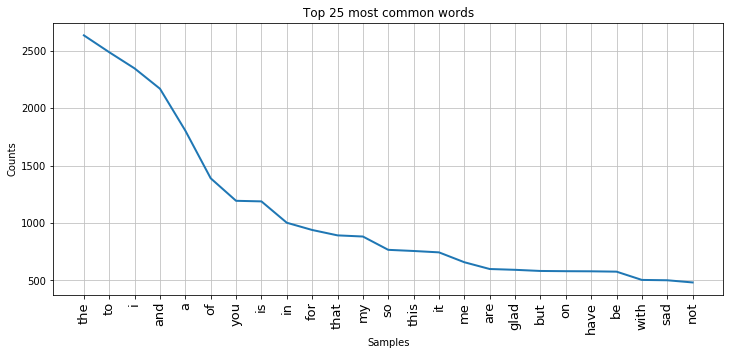

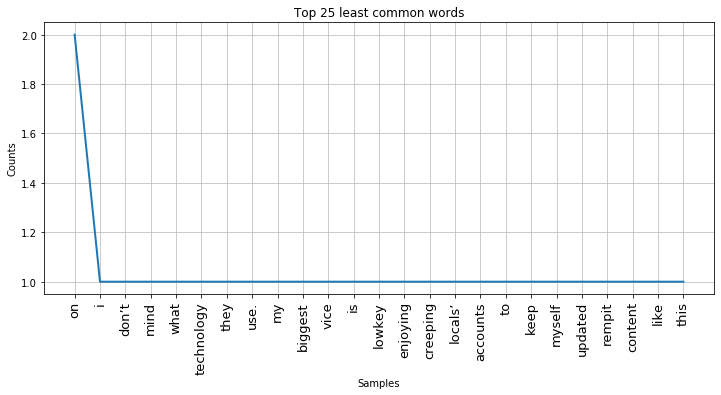

Text(0.5, 1.0, 'log-log plot of words frequency')

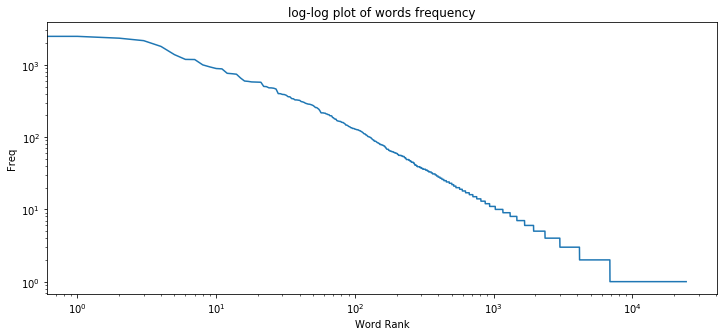

In [8]:
# plot word frequency distribution of most common words
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# plot word frequency distribution of least common words
plt.figure(figsize=(12,5))
plt.title('Top 25 least common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words[-26:])
fd.plot(cumulative=False)

# log-log plot
word_counts = sorted(collections.Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency')

* log-log plot for the words frequency which is similar to the previous frequency graph but includes all words and is plotted on a base 10 logarithmic scale which helps us visualize the rapidly diminishing frequency of words as their rank drops
* 'i', 'and', 'the' etc. are highly used in human expressions. These kind of words usually appear equally in both negative and positive oriented expressions and as such they bring very little information that can be incorporated in the model so we will have to get rid of them down the road

### Preprocessing Data

####  Cleaning tweet texts

In [9]:
import string
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'['+string.punctuation+']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

In [10]:
# clean dataframe's text column
df['tweet'] = df['tweet'].apply(processTweet)
df_test['text']=df_test['text'].apply(processTweet)
# preview some cleaned tweets
df['tweet'].head()

0    shouldn have say this but this twt referring w...
1    don’ get depressed went through this and ’ lot...
2                             certinho amg deixa assim
3    girl made dinner the middle workout that some ...
4    literally feel depressed but mom making get la...
Name: tweet, dtype: object

#### Lemmatization

In [11]:
from nltk.stem import WordNetLemmatizer
w_tokenizer=nltk.tokenize.WhitespaceTokenizer()
lemmatizer=WordNetLemmatizer()
def lemmatize_text(text):
    return[lemmatizer.lemmatize(w)for w in w_tokenizer.tokenize(text)]

In [12]:
df['lemm_tweet']=df.tweet.apply(lemmatize_text)
df['temp_tweet']=[' '.join(map(str, l))for l in df['lemm_tweet']]

df_test['lemm_tweet']=df_test.text.apply(lemmatize_text)
df_test['text']=[' '.join(map(str, l)) for l in df_test['lemm_tweet']]

df.head()

,id,username,tweet,date,retweets,lemm_tweet,temp_tweet
0,1265297824595369985,DEGABGED,shouldn have say this but this twt referring w...,2020-05-26 15:04:44+00:00,0,"[shouldn, have, say, this, but, this, twt, ref...",shouldn have say this but this twt referring w...
1,1265297821302951937,johngigliotti1,don’ get depressed went through this and ’ lot...,2020-05-26 15:04:43+00:00,0,"[don’, get, depressed, went, through, this, an...",don’ get depressed went through this and ’ lot...
2,1265297819298037760,JELLYCB97,certinho amg deixa assim,2020-05-26 15:04:42+00:00,0,"[certinho, amg, deixa, assim]",certinho amg deixa assim
3,1265297815485345792,ChickenColeman,girl made dinner the middle workout that some ...,2020-05-26 15:04:41+00:00,0,"[girl, made, dinner, the, middle, workout, tha...",girl made dinner the middle workout that some ...
4,1265297814441078785,mirrorrsedge,literally feel depressed but mom making get la...,2020-05-26 15:04:41+00:00,0,"[literally, feel, depressed, but, mom, making,...",literally feel depressed but mom making get la...


In [13]:
df_test.head()

,text,label,lemm_tweet
0,what said,0,"[what, said]"
1,plus you added commercial the experience tacky,1,"[plus, you, added, commercial, the, experience..."
2,didn today must mean need take another trip,0,"[didn, today, must, mean, need, take, another,..."
3,really aggressive blast obnoxious entertainmen...,0,"[really, aggressive, blast, obnoxious, enterta..."
4,and really big bad thing about,0,"[and, really, big, bad, thing, about]"


#### Removing stop words

In [14]:
nltk.download('stopwords')
from nltk.corpus import stopwords
 
stopwords_english = stopwords.words('english')
print (stopwords_english)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /home/ashish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Note: We cannot eliminate all stop words here as certain stop words are needed toexpress the sentiment of the tweets when considered in a sentence. Eg: “sad” vs “isn’t sad” and “makes sense” vs “makes no sense” potray completelydifferent sentiments in a sentence. Hence we can’t eliminate all stop words

In [15]:
from textblob import Word 
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]   
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # remove all stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords_english]

def remove_words(word_list):
    remove = ['i','me','my','flight','hour','minute','wa','airline','bag','plane','cancelled','myself','we','our','ours','ourselves','you',"you're","you've","you'll","you'd",'your','yours','yourself','yourselves','he','him','his','himself','she',"she's",'her','hers','herself','it',"it's",'its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that',"that'll",'these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','...','“','”','’','...']
    return [w for w in word_list if w not in remove]

In [16]:
# tokenize message column and create a column for tokens
df['temp']=df['temp_tweet'].apply(text_process)
df['tokens']=df['temp'].apply(remove_words)

df_test['temp']=df_test['text'].apply(text_process)
df_test['tokens']=df_test['temp'].apply(remove_words)

df[['tweet','temp_tweet','temp','tokens']]

,tweet,temp_tweet,temp,tokens
0,shouldn have say this but this twt referring w...,shouldn have say this but this twt referring w...,"[say, twt, referring, depressed, alone]","[say, twt, referring, depressed, alone]"
1,don’ get depressed went through this and ’ lot...,don’ get depressed went through this and ’ lot...,"[don’, get, depressed, went, ’, lot, take, goo...","[don’, get, depressed, went, lot, take, good, ..."
2,certinho amg deixa assim,certinho amg deixa assim,"[certinho, amg, deixa, assim]","[certinho, amg, deixa, assim]"
3,girl made dinner the middle workout that some ...,girl made dinner the middle workout that some ...,"[girl, made, dinner, middle, workout, wonder, ...","[girl, made, dinner, middle, workout, wonder, ..."
4,literally feel depressed but mom making get la...,literally feel depressed but mom making get la...,"[literally, feel, depressed, mom, making, get,...","[literally, feel, depressed, mom, making, get,..."
...,...,...,...,...
5616,depends what you ran content dnc slaps but hav...,depends what you ran content dnc slap but have...,"[depends, ran, content, dnc, slap, noticed, dn...","[depends, ran, content, dnc, slap, noticed, dn..."
5617,amen love that you mention judge content chara...,amen love that you mention judge content chara...,"[amen, love, mention, judge, content, characte...","[amen, love, mention, judge, content, characte..."
5618,dds uncle who always call out about content po...,dd uncle who always call out about content pos...,"[dd, uncle, always, call, content, posted, bla...","[dd, uncle, always, call, content, posted, bla..."
5619,what meant was that just wanted the option pla...,what meant wa that just wanted the option play...,"[meant, wa, wanted, option, play, apple, conte...","[meant, wanted, option, play, apple, content, ..."


In [17]:
df_test.head()

,text,label,lemm_tweet,temp,tokens
0,what said,0,"[what, said]",[said],[said]
1,plus you added commercial the experience tacky,1,"[plus, you, added, commercial, the, experience...","[plus, added, commercial, experience, tacky]","[plus, added, commercial, experience, tacky]"
2,didn today must mean need take another trip,0,"[didn, today, must, mean, need, take, another,...","[today, must, mean, need, take, another, trip]","[today, must, mean, need, take, another, trip]"
3,really aggressive blast obnoxious entertainmen...,0,"[really, aggressive, blast, obnoxious, enterta...","[really, aggressive, blast, obnoxious, enterta...","[really, aggressive, blast, obnoxious, enterta..."
4,and really big bad thing about,0,"[and, really, big, bad, thing, about]","[really, big, bad, thing]","[really, big, bad, thing]"


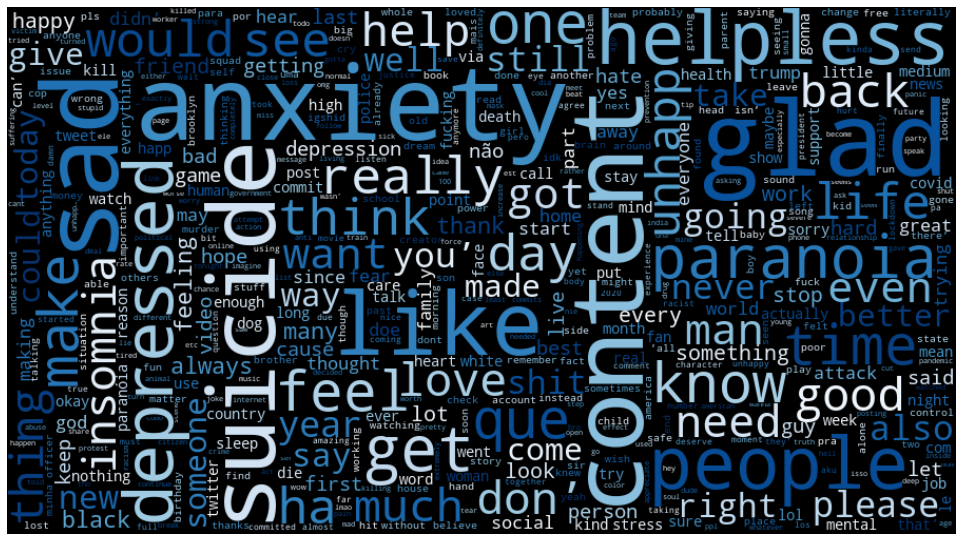

In [18]:
# split sentences to get individual words
all_words = []
for line in df['tokens']: 
    all_words.extend(line)
    
    
# create a word frequency dictionary
wordfreq = collections.Counter(all_words)# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [19]:
import collections 
all_words = []
for line in list(df['tokens']):
    for word in line:
        all_words.append(word.lower())
        
collections.Counter(all_words).most_common(10)

[('sad', 628),
 ('glad', 610),
 ('anxiety', 596),
 ('content', 572),
 ('suicide', 475),
 ('like', 418),
 ('helpless', 398),
 ('people', 383),
 ('depressed', 344),
 ('get', 285)]

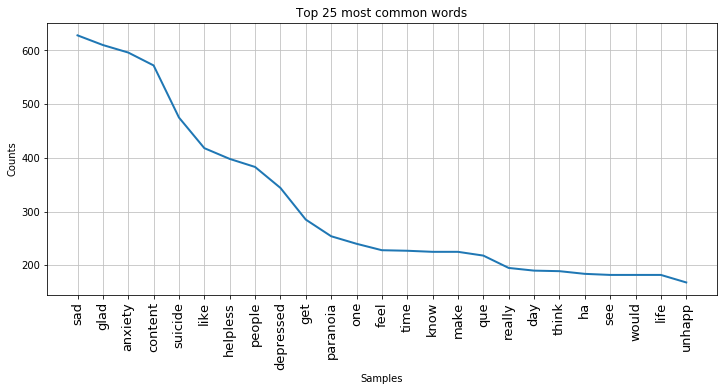

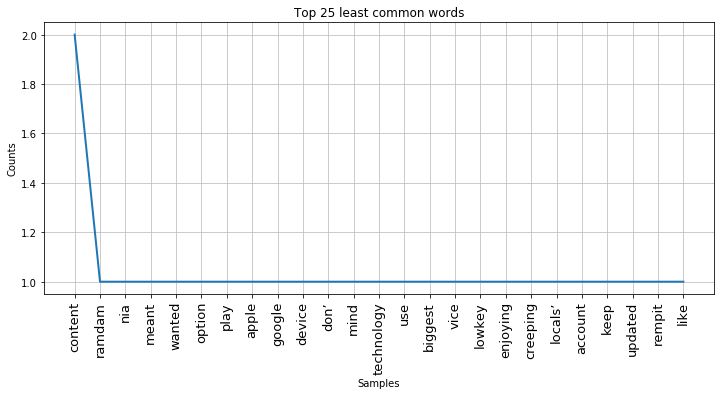

Text(0.5, 1.0, 'log-log plot of words frequency')

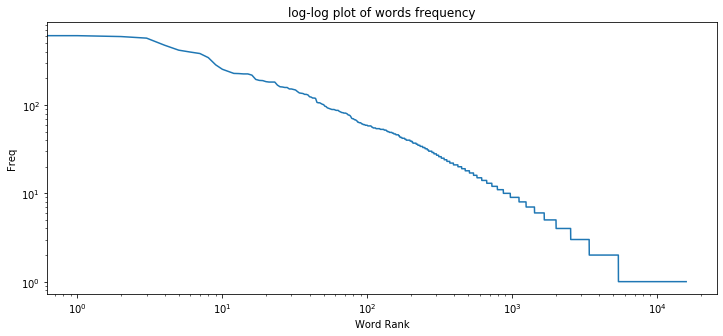

In [20]:
# plot word frequency distribution of most common words
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# plot word frequency distribution of least common words
plt.figure(figsize=(12,5))
plt.title('Top 25 least common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words[-26:])
fd.plot(cumulative=False)

# log-log plot
word_counts = sorted(collections.Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency')

In [21]:
df.head()

,id,username,tweet,date,retweets,lemm_tweet,temp_tweet,temp,tokens
0,1265297824595369985,DEGABGED,shouldn have say this but this twt referring w...,2020-05-26 15:04:44+00:00,0,"[shouldn, have, say, this, but, this, twt, ref...",shouldn have say this but this twt referring w...,"[say, twt, referring, depressed, alone]","[say, twt, referring, depressed, alone]"
1,1265297821302951937,johngigliotti1,don’ get depressed went through this and ’ lot...,2020-05-26 15:04:43+00:00,0,"[don’, get, depressed, went, through, this, an...",don’ get depressed went through this and ’ lot...,"[don’, get, depressed, went, ’, lot, take, goo...","[don’, get, depressed, went, lot, take, good, ..."
2,1265297819298037760,JELLYCB97,certinho amg deixa assim,2020-05-26 15:04:42+00:00,0,"[certinho, amg, deixa, assim]",certinho amg deixa assim,"[certinho, amg, deixa, assim]","[certinho, amg, deixa, assim]"
3,1265297815485345792,ChickenColeman,girl made dinner the middle workout that some ...,2020-05-26 15:04:41+00:00,0,"[girl, made, dinner, the, middle, workout, tha...",girl made dinner the middle workout that some ...,"[girl, made, dinner, middle, workout, wonder, ...","[girl, made, dinner, middle, workout, wonder, ..."
4,1265297814441078785,mirrorrsedge,literally feel depressed but mom making get la...,2020-05-26 15:04:41+00:00,0,"[literally, feel, depressed, but, mom, making,...",literally feel depressed but mom making get la...,"[literally, feel, depressed, mom, making, get,...","[literally, feel, depressed, mom, making, get,..."


In [22]:
df['clean_tweet'] = [' '.join(map(str, l)) for l in df['tokens']]
df=df.drop(columns=['username','lemm_tweet','tweet','temp','temp_tweet','date','retweets'])
df.head()

,id,tokens,clean_tweet
0,1265297824595369985,"[say, twt, referring, depressed, alone]",say twt referring depressed alone
1,1265297821302951937,"[don’, get, depressed, went, lot, take, good, ...",don’ get depressed went lot take good guy winn...
2,1265297819298037760,"[certinho, amg, deixa, assim]",certinho amg deixa assim
3,1265297815485345792,"[girl, made, dinner, middle, workout, wonder, ...",girl made dinner middle workout wonder woman s...
4,1265297814441078785,"[literally, feel, depressed, mom, making, get,...",literally feel depressed mom making get last t...


In [23]:
df_test['clean_tweet'] = [' '.join(map(str, l)) for l in df_test['tokens']]
df_test=df_test.drop(columns=['text','lemm_tweet','temp'])
df_test.head()

,label,tokens,clean_tweet
0,0,[said],said
1,1,"[plus, added, commercial, experience, tacky]",plus added commercial experience tacky
2,0,"[today, must, mean, need, take, another, trip]",today must mean need take another trip
3,0,"[really, aggressive, blast, obnoxious, enterta...",really aggressive blast obnoxious entertainmen...
4,0,"[really, big, bad, thing]",really big bad thing


In [24]:
from nltk import bigrams
terms_bigram = [list(bigrams(tweet)) for tweet in df.tokens]
terms_bigram[0]

[('say', 'twt'),
 ('twt', 'referring'),
 ('referring', 'depressed'),
 ('depressed', 'alone')]

In [25]:
import itertools
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))
# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)
bigram_counts.most_common(25)

[(('commit', 'suicide'), 37),
 (('suicide', 'squad'), 36),
 (('feel', 'helpless'), 35),
 (('mental', 'health'), 32),
 (('feel', 'like'), 30),
 (('content', 'creator'), 30),
 (('anxiety', 'attack'), 28),
 (('glad', 'see'), 26),
 (('depression', 'anxiety'), 24),
 (('glad', 'hear'), 24),
 (('social', 'medium'), 21),
 (('suicide', 'prevention'), 20),
 (('anxiety', 'depression'), 20),
 (('glad', 'you’'), 20),
 (('committed', 'suicide'), 19),
 (('make', 'sad'), 18),
 (('don’', 'know'), 18),
 (('give', 'anxiety'), 18),
 (('one', 'day'), 17),
 (('commits', 'suicide'), 17),
 (('stress', 'anxiety'), 17),
 (('glad', 'got'), 17),
 (('glad', 'know'), 17),
 (('panic', 'attack'), 16),
 (('many', 'people'), 15)]

/home/ashish/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12290 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ashish/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ashish/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12290 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/ashish/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0, flags=flags)


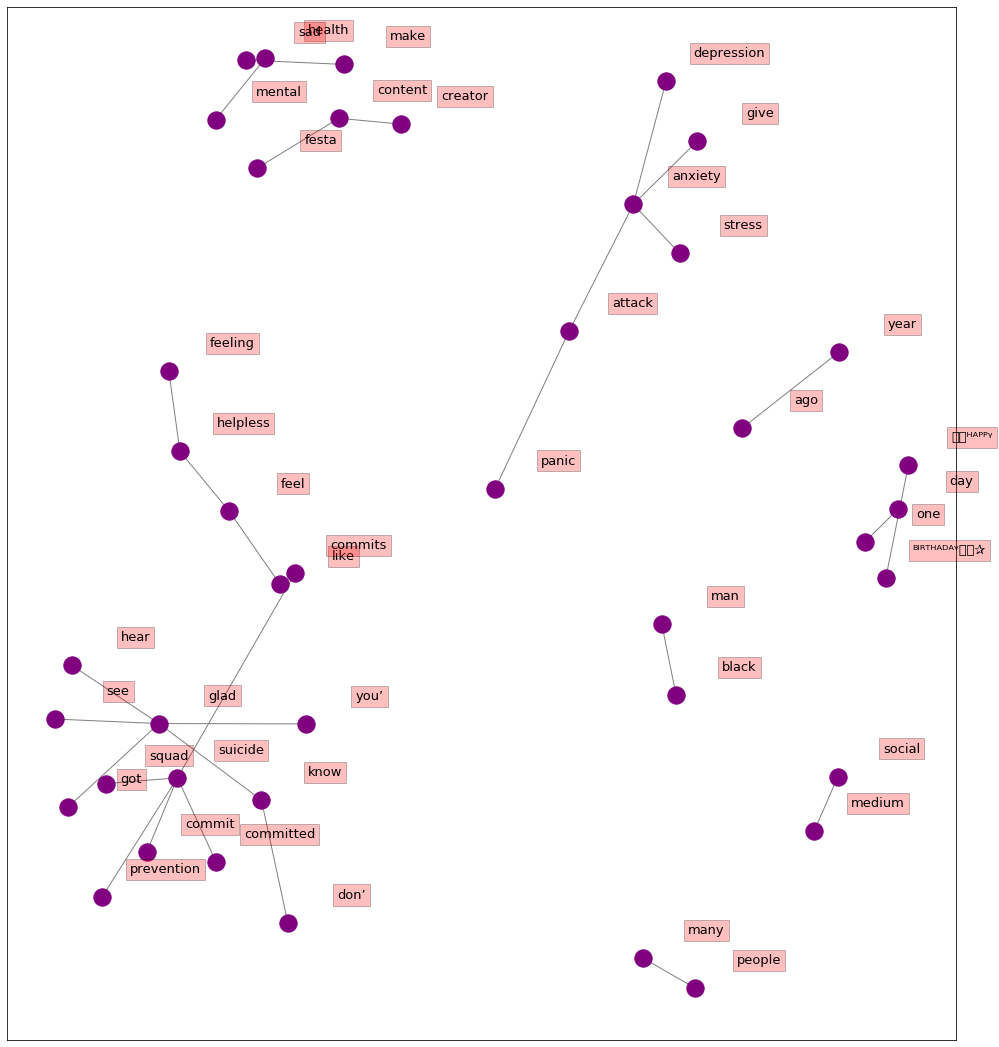

In [30]:
import networkx as nx
bigram_df = pd.DataFrame(bigram_counts.most_common(30),columns=['bigram', 'count'])

# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("sad", weight=100)

fig, ax = plt.subplots(figsize=(17, 19))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)

plt.show()

#### Bag of Word and TF IDF

In [31]:
# vectorize
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['clean_tweet'])
print(len(bow_transformer.vocabulary_))
# transform the entire DataFrame of messages
messages_bow = bow_transformer.transform(df['clean_tweet'])
# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)
# from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
# to transform the entire bag-of-words corpus
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

15908
Shape of Sparse Matrix:  (5585, 15908)
Amount of Non-Zero occurences:  56295
(5585, 15908)


### TextBlob vs VADER sentiment

#### 1. TextBlob

In [32]:
##textBlob
from textblob import TextBlob
def get_tweet_sentiment_tb(clean_tweet):

    # create TextBlob object of the passed tweet text
    analysis = TextBlob(clean_tweet)
    if analysis.sentiment.polarity > 0:
        sentiment = 1
    else:
        sentiment = 0
    return sentiment

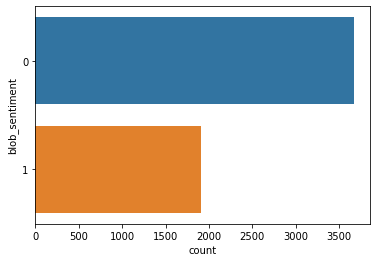

In [33]:
df["blob_sentiment"]=df["clean_tweet"].apply(get_tweet_sentiment_tb)
df_blob=df[['clean_tweet','blob_sentiment']]

import seaborn as sns
sns.countplot(y="blob_sentiment", data=df_blob)

In [34]:
collections.Counter(df_blob['blob_sentiment'])

Counter({0: 3676, 1: 1909})

In [35]:
X_train=df_blob["clean_tweet"]
y_train=df_blob["blob_sentiment"]

In [36]:
blob=[]

#### Naive bayes Classifier

In [37]:
X_test=df_test['clean_tweet']
y_test=df_test['label']

In [38]:
# create pipeline
pipeline = Pipeline([
('bow', CountVectorizer(strip_accents='ascii',
stop_words='english',
lowercase=True)), # strings to token integer counts
('tfidf', TfidfTransformer()),
# integer counts to weighted TF-IDF scores
('classifier', MultinomialNB()),
# train on TF-IDF vectors w/ Naive Bayes classifier
    ])
# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-2, 1e-3),
             }
# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Best Model: 0.733574 using {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}


Mean: 0.720676 Stdev:(0.091768) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.733574 Stdev:(0.110543) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.718528 Stdev:(0.085309) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.728560 Stdev:(0.103132) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}
Mean: 0.719612 Stdev:(0.086921) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.724808 Stdev:(0.111282) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.716746 Stdev:(0.081410) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.717645 Stdev:(0.102506) with: {'bow__ngram_range'

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   14.5s finished


In [39]:
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )
# get predictions from best model above
y_preds = model_NB.predict(X_test)
print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))
blob.append(accuracy_score(y_test, y_preds))

accuracy score:  0.5444672131147541


confusion matrix: 
 [[6074 6203]
 [ 466 1897]]


              precision    recall  f1-score   support

           0       0.93      0.49      0.65     12277
           1       0.23      0.80      0.36      2363

    accuracy                           0.54     14640
   macro avg       0.58      0.65      0.50     14640
weighted avg       0.82      0.54      0.60     14640



#### Decision Tree Classifier

In [41]:
# create pipeline
X_train=df_blob["clean_tweet"]
y_train=df_blob["blob_sentiment"]
from sklearn.tree import DecisionTreeClassifier
pipeline = Pipeline([
('bow', CountVectorizer(strip_accents='ascii',
stop_words='english',
lowercase=True)),
    # strings to token integer counts
('tfidf', TfidfTransformer()),
    # integer counts to weighted TF-IDF scores
('classifier', DecisionTreeClassifier()),
    # train on TF-IDFvectors w/ DecisionTreeClassifier
])
# this is where we define the values for GridSearchCV to iterate over

parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
                'tfidf__use_idf': (True, False)
            }
# do 10-fold cross validation for each of the 6 possible combinations of the above params

grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   48.8s finished



Best Model: 0.797322 using {'bow__ngram_range': (1, 2), 'tfidf__use_idf': True}


Mean: 0.783184 Stdev:(0.141512) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': True}
Mean: 0.786036 Stdev:(0.138355) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': False}
Mean: 0.797322 Stdev:(0.143536) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': True}
Mean: 0.790516 Stdev:(0.141214) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': False}


In [42]:
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )
# get predictions from best model above
y_preds = model_NB.predict(X_test)
print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))
blob.append(accuracy_score(y_test, y_preds))

accuracy score:  0.7376366120218579


confusion matrix: 
 [[9285 2992]
 [ 849 1514]]


              precision    recall  f1-score   support

           0       0.92      0.76      0.83     12277
           1       0.34      0.64      0.44      2363

    accuracy                           0.74     14640
   macro avg       0.63      0.70      0.63     14640
weighted avg       0.82      0.74      0.77     14640



#### SVC

In [44]:
# create pipeline
X_train=df_blob["clean_tweet"]
y_train=df_blob["blob_sentiment"]
from sklearn.svm import SVC
pipeline = Pipeline([
('bow', CountVectorizer(strip_accents='ascii',
stop_words='english',
lowercase=True)), 
    # strings to token integer counts
('tfidf', TfidfTransformer()),
    # integer counts to weighted TF-IDF scores
('classifier', SVC()),
    # train on TF-IDF vectors w/ SVC
])
    # this is where we define the values  for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
'tfidf__use_idf': (True, False)
}
# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.2min finished



Best Model: 0.785887 using {'bow__ngram_range': (1, 1), 'tfidf__use_idf': False}


Mean: 0.783739 Stdev:(0.135087) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': True}
Mean: 0.785887 Stdev:(0.145025) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': False}
Mean: 0.770496 Stdev:(0.144681) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': True}
Mean: 0.776576 Stdev:(0.144960) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': False}


In [45]:
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )
# get predictions from best model above
y_preds = model_NB.predict(X_test)
print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))
blob.append(accuracy_score(y_test, y_preds))

accuracy score:  0.8085382513661202


confusion matrix: 
 [[10412  1865]
 [  938  1425]]


              precision    recall  f1-score   support

           0       0.92      0.85      0.88     12277
           1       0.43      0.60      0.50      2363

    accuracy                           0.81     14640
   macro avg       0.68      0.73      0.69     14640
weighted avg       0.84      0.81      0.82     14640



#### XGBClassifier

In [47]:
# create pipeline
X_train=df_blob["clean_tweet"]
y_train=df_blob["blob_sentiment"]
from xgboost import XGBClassifier
pipeline = Pipeline([
('bow', CountVectorizer(strip_accents='ascii',
stop_words='english',
lowercase=True)), 
    # strings to token integer counts
('tfidf', TfidfTransformer()),
    # integer counts to weighted TF-IDF scores
('classifier', XGBClassifier()),
    # train on TF-IDF vectors w/ XGBClassifier
])
    # this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
'tfidf__use_idf': (True, False)
}
    # do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)
    # summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )
# get predictions from best model above
y_preds = model_NB.predict(X_test)
print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.8min finished



Best Model: 0.763698 using {'bow__ngram_range': (1, 1), 'tfidf__use_idf': False}


Mean: 0.762980 Stdev:(0.152788) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': True}
Mean: 0.763698 Stdev:(0.154136) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': False}
Mean: 0.762449 Stdev:(0.151296) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': True}
Mean: 0.763163 Stdev:(0.154956) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': False}
accuracy score:  0.8207650273224044


confusion matrix: 
 [[11334   943]
 [ 1681   682]]


              precision    recall  f1-score   support

           0       0.87      0.92      0.90     12277
           1       0.42      0.29      0.34      2363

    accuracy                           0.82     14640
   macro avg       0.65      0.61      0.62     14640
weighted avg       0.80      0.82      0.81     14640



In [48]:
blob.append(accuracy_score(y_test, y_preds))
blob

[0.5444672131147541,
 0.7376366120218579,
 0.8085382513661202,
 0.8207650273224044]

#### 2. VaderSentiment

In [50]:
#vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def get_tweet_sentiment_vd(clean_tweet):
    analyzer = SentimentIntensityAnalyzer()
    sentiment=0
    vs = analyzer.polarity_scores(clean_tweet)
    if vs['compound'] >0:
        sentiment = 1
    return sentiment

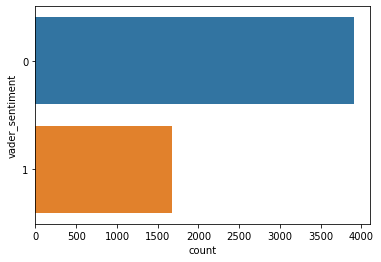

In [51]:
df["vader_sentiment"]=df["clean_tweet"].apply(get_tweet_sentiment_vd)
df_vader=df[['clean_tweet','vader_sentiment']]
sns.countplot(y="vader_sentiment", data=df_vader)

In [52]:
collections.Counter(df_vader['vader_sentiment'])

Counter({0: 3913, 1: 1672})

In [53]:
X_train=df_vader["clean_tweet"]
y_train=df_vader["vader_sentiment"]

In [54]:
vad=[]

#### Naive Bayes classifier

In [55]:
# create pipeline
pipeline = Pipeline([
('bow', CountVectorizer(strip_accents='ascii',
stop_words='english',
lowercase=True)), # strings to token integer counts
('tfidf', TfidfTransformer()),
# integer counts to weighted TF-IDF scores
('classifier', MultinomialNB()),
# train on TF-IDF vectors w/ Naive Bayes classifier
])
# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
'tfidf__use_idf': (True, False),
'classifier__alpha': (1e-2, 1e-3),
}
# do 10-fold cross validation for each of the 6 possible combinations of the␣
, → above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )
# get predictions from best model above
y_preds = model_NB.predict(X_test)
print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))
vad.append(accuracy_score(y_test, y_preds))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   13.6s finished



Best Model: 0.754716 using {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}


Mean: 0.747906 Stdev:(0.084865) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.754716 Stdev:(0.110957) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.740921 Stdev:(0.078303) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.750239 Stdev:(0.095613) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}
Mean: 0.750957 Stdev:(0.089397) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.752038 Stdev:(0.117931) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.742898 Stdev:(0.082524) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.747918 Stdev:(0.100219) with: {'bow__ngram_range'

#### Decision Tree Classifier

In [56]:
# create pipeline
from sklearn.tree import DecisionTreeClassifier
pipeline = Pipeline([
('bow', CountVectorizer(strip_accents='ascii',
stop_words='english',
lowercase=True)), 
# strings to token integer counts
('tfidf', TfidfTransformer()),
# integer counts to weighted TF-IDF scores
('classifier', DecisionTreeClassifier()),
# train on TF-IDF vectors w/ DecisionTreeClassifier
])
# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False)
}
# do 10-fold cross validation for each of the 6 possible combinations of the␣
, → above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )
# get predictions from best model above
y_preds = model_NB.predict(X_test)
print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))

vad.append(accuracy_score(y_test, y_preds))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   53.3s finished



Best Model: 0.760081 using {'bow__ngram_range': (1, 2), 'tfidf__use_idf': True}


Mean: 0.747190 Stdev:(0.144040) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': True}
Mean: 0.752570 Stdev:(0.149911) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': False}
Mean: 0.760081 Stdev:(0.146600) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': True}
Mean: 0.753988 Stdev:(0.143503) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': False}
accuracy score:  0.6877049180327869


confusion matrix: 
 [[8554 3723]
 [ 849 1514]]


              precision    recall  f1-score   support

           0       0.91      0.70      0.79     12277
           1       0.29      0.64      0.40      2363

    accuracy                           0.69     14640
   macro avg       0.60      0.67      0.59     14640
weighted avg       0.81      0.69      0.73     14640



#### SVC

In [57]:
# create pipeline
from sklearn.svm import SVC
pipeline = Pipeline([
('bow', CountVectorizer(strip_accents='ascii',
stop_words='english',
lowercase=True)), 
# strings to token integer counts
('tfidf', TfidfTransformer()),
# integer counts to weighted TF-IDF scores
('classifier', SVC()),
# train on TF-IDF vectors w/DecisionTreeClassifier
])
# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],'tfidf__use_idf': (True, False)}
# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))
    
    
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )
# get predictions from best model above
y_preds = model_NB.predict(X_test)
print('\n')
print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))

vad.append(accuracy_score(y_test, y_preds))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.1min finished



Best Model: 0.794306 using {'bow__ngram_range': (1, 1), 'tfidf__use_idf': True}


Mean: 0.794306 Stdev:(0.146551) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': True}
Mean: 0.790725 Stdev:(0.163093) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': False}
Mean: 0.782138 Stdev:(0.158260) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': True}
Mean: 0.782669 Stdev:(0.165562) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': False}


accuracy score:  0.821584699453552


confusion matrix: 
 [[10631  1646]
 [  966  1397]]


              precision    recall  f1-score   support

           0       0.92      0.87      0.89     12277
           1       0.46      0.59      0.52      2363

    accuracy                           0.82     14640
   macro avg       0.69      0.73      0.70     14640
weighted avg       0.84      0.82      0.83     14640



#### XGBClassifier

In [58]:
# create pipeline
from xgboost import XGBClassifier
pipeline = Pipeline([
('bow', CountVectorizer(strip_accents='ascii',
stop_words='english',
lowercase=True)),
# strings to token integer counts
('tfidf', TfidfTransformer()),
# integer counts to weighted TF-IDF scores
('classifier', XGBClassifier()),
# train on TF-IDF vectors w/ DecisionTreeClassifier
])
# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
'tfidf__use_idf': (True, False)
}
# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))
    
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )
# get predictions from best model above
y_preds = model_NB.predict(X_test)
print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))
vad.append(accuracy_score(y_test, y_preds))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.7min finished



Best Model: 0.772117 using {'bow__ngram_range': (1, 2), 'tfidf__use_idf': True}


Mean: 0.764063 Stdev:(0.173432) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': True}
Mean: 0.765675 Stdev:(0.174361) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': False}
Mean: 0.772117 Stdev:(0.165164) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': True}
Mean: 0.767105 Stdev:(0.172253) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': False}
accuracy score:  0.8226775956284152


confusion matrix: 
 [[11531   746]
 [ 1850   513]]


              precision    recall  f1-score   support

           0       0.86      0.94      0.90     12277
           1       0.41      0.22      0.28      2363

    accuracy                           0.82     14640
   macro avg       0.63      0.58      0.59     14640
weighted avg       0.79      0.82      0.80     14640



In [59]:
print("Accuracy with Textblob:-")
print("Naive Bayes Classifier:",blob[0])
print("Decision Tree Classifier:",blob[1])
print("SVC:",blob[2])
print("XGBClassifier:",blob[3])
print("\nAccuracy with vaderSentiment:-")
print("Naive Bayes Classifier:",vad[0])
print("Decision Tree Classifier:",vad[1])
print("SVC:",vad[2])
print("XGBClassifier:",vad[3])

Accuracy with Textblob:-
Naive Bayes Classifier: 0.5444672131147541
Decision Tree Classifier: 0.7376366120218579
SVC: 0.8085382513661202
XGBClassifier: 0.8207650273224044

Accuracy with vaderSentiment:-
Naive Bayes Classifier: 0.6187841530054645
Decision Tree Classifier: 0.6877049180327869
SVC: 0.821584699453552
XGBClassifier: 0.8226775956284152


###### SVC with vaderSentiment gives the most accurate model for the given test dataset